In [8]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms.v2 import RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, Dataset, DataLoader
import matplotlib.pyplot as plt

from src.data_utils import TransformDataset

# Этап 1. Загрузка и предобработка данных

acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
Количество изображений в train: 1882
Количество изображений в val: 470
Список классов ['acc_long_600_mg', 'advil_ultra_forte', 'akineton_2_mg', 'algoflex_forte_dolo_400_mg', 'algoflex_rapid_400_mg', 'algopyrin_500_mg', 'ambroxol_egis_30_mg', 'apranax_550_mg', 'aspirin_ultra_500_mg', 'atoris_20_mg', 'atorvastatin_teva_20_mg', 'betaloc_50_mg', 'bila_git', 'c_vitamin_teva_500_mg', 'calci_kid', 'cataflam_50_mg', 'cataflam_dolo_25_mg', 'cetirizin_10_mg', 'cold_fx', 'coldrex', 'concor_10_mg', 'concor_5_mg', 'condrosulf_800_mg', 'controloc_20_mg', 'covercard_plus_10_mg_2_5_mg_5_mg', 'coverex_4_mg', 'diclopram_75-mg_20-mg', 'dorithricin_mentol', 'dulsevia_60_mg', 'enterol_250_mg', 'favipiravir_meditop_200_mg', 'ibumax_400_mg', 'jutavit_c_vitamin', 'jutavit_cink', 'kalcium_magnezium_cink', 'kalium_r', 'koleszterin_kontroll', 'lactamed', 

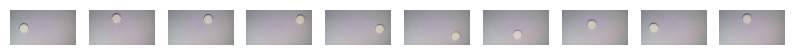

In [9]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transforms = Compose([
    RandomHorizontalFlip(p=0.2),
    RandomVerticalFlip(p=0.2),
    RandomRotation([-5, 5], fill=255.),
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean, std),
])

test_transforms = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean, std)
])

train_data = ImageFolder('./data/train')
test_data = ImageFolder('./data/test')

fig = plt.figure(figsize=(10,5))
for index in range (1, 11):
    image, label = train_data[index]
    print(train_data.classes[label])
    plt.subplot(1, 10, index)
    plt.imshow(image)
    plt.axis('off')

train_dataset, val_dataset = random_split(train_data, [0.8, 0.2])

train_dataset = TransformDataset(train_dataset, train_transforms)
val_dataset = TransformDataset(val_dataset, test_transforms)
test_dataset = TransformDataset(test_data, test_transforms)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, pin_memory_device="cuda")
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True, pin_memory_device="cuda")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True, pin_memory_device="cuda")

print("Количество изображений в train:", len(train_dataset))
print("Количество изображений в val:", len(val_dataset))
print("Список классов", train_data.classes)
print("Количество классов", len(train_data.classes))

# Этап 2. Объявление модели

In [3]:
from torchsummary import summary
from torchvision.models import mobilenet_v3_small
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = mobilenet_v3_small(weights='IMAGENET1K_V1')
model.classifier = nn.Linear(in_features=576, out_features=84, bias=True)
model.to(device)
for param in model.parameters():
    param.requires_grad = False


for param in model.classifier.parameters():
    param.requires_grad = True

summary(model, input_size=(3, 224, 224)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

# Этап 3. Дообучение

In [4]:
from torchvision.models import mobilenet_v3_small
import torch.nn as nn
import torch.optim as optim
import torch
from tqdm.auto import tqdm

patience = 3
target_acc = 75
epochs_no_improve = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 30
best_vloss = 1e5

def train_one_epoch(epoch_index):
    running_loss = 0.0
    epoch_loss = 0.0 
    num_batches = 0
    
    train_bar = tqdm(
        train_loader,
        desc=f"Тренировка (эпоха {epoch_index + 1})",
    )

    for batch_index, (inputs, labels) in enumerate(train_bar):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value
        epoch_loss += loss_value
        num_batches += 1

        if (batch_index + 1) % 20 == 0:
            running_loss = 0.0

    avg_loss = epoch_loss / num_batches
    return avg_loss


for epoch in range(EPOCHS):
    model.train(True)
    avg_loss = train_one_epoch(epoch)

    model.eval()
    running_vloss = 0.0
    val_bar = tqdm(
        val_loader,
        desc=f"Валидация (эпоха {epoch + 1})",
    )
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for i, vdata in enumerate(val_bar):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device, non_blocking=True)
            vlabels = vlabels.to(device, non_blocking=True)

            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

            vpreds = voutputs.argmax(dim=1)
            val_correct += (vpreds == vlabels).sum().item()
            val_total += vlabels.size(0)

    avg_vloss = running_vloss / (i + 1)
    val_acc = val_correct / val_total
    val_acc_percent = round(val_acc * 100, 2)
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'meds_classifier.pt'
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_path)
    else:
        epochs_no_improve += 1

    if val_acc_percent >= target_acc and epochs_no_improve >= patience:
        break

    print(f'Ошибка train {avg_loss}, ошибка val {avg_vloss}, точность на валидации {val_acc_percent}% \n') 

d:\tablets\-tablet-classifier\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Валидация (эпоха 1): 100%|██████████| 15/15 [00:19<00:00,  1.33s/it]


Ошибка train 4.253552230737977, ошибка val 4.373778820037842, точность на валидации 2.55% 



Валидация (эпоха 2): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Ошибка train 3.6491454617451815, ошибка val 4.373295783996582, точность на валидации 2.13% 



Валидация (эпоха 3): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Ошибка train 3.2283269025511663, ошибка val 4.338551044464111, точность на валидации 2.77% 



Валидация (эпоха 4): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Ошибка train 2.9032079405703786, ошибка val 4.3023786544799805, точность на валидации 4.89% 



Валидация (эпоха 5): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Ошибка train 2.6326418205843134, ошибка val 4.314845561981201, точность на валидации 5.11% 



Валидация (эпоха 6): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Ошибка train 2.4025466159238653, ошибка val 4.215503215789795, точность на валидации 6.6% 



Валидация (эпоха 7): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Ошибка train 2.230765037617441, ошибка val 3.934854745864868, точность на валидации 7.23% 



Валидация (эпоха 8): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Ошибка train 2.0391861564022, ошибка val 3.3257956504821777, точность на валидации 14.04% 



Валидация (эпоха 9): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Ошибка train 1.9022280462717607, ошибка val 2.67323637008667, точность на валидации 29.79% 



Валидация (эпоха 10): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Ошибка train 1.804585822557999, ошибка val 2.0796499252319336, точность на валидации 50.64% 



Валидация (эпоха 11): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Ошибка train 1.684957084009203, ошибка val 1.7374131679534912, точность на валидации 62.13% 



Валидация (эпоха 12): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Ошибка train 1.5823827901128995, ошибка val 1.5928146839141846, точность на валидации 65.11% 



Валидация (эпоха 13): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Ошибка train 1.5406504303722057, ошибка val 1.4602149724960327, точность на валидации 69.15% 



Валидация (эпоха 14): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Ошибка train 1.4385748677334542, ошибка val 1.4088984727859497, точность на валидации 68.94% 



Валидация (эпоха 15): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Ошибка train 1.410763924404726, ошибка val 1.3461430072784424, точность на валидации 71.91% 



Валидация (эпоха 16): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Ошибка train 1.3164789777691082, ошибка val 1.2834235429763794, точность на валидации 72.13% 



Валидация (эпоха 17): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Ошибка train 1.2810096235598547, ошибка val 1.2781364917755127, точность на валидации 73.19% 



Валидация (эпоха 18): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Ошибка train 1.213500575493958, ошибка val 1.1938235759735107, точность на валидации 74.89% 



Валидация (эпоха 19): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Ошибка train 1.161478112309666, ошибка val 1.1428889036178589, точность на валидации 75.11% 



Валидация (эпоха 20): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Ошибка train 1.106943167872348, ошибка val 1.1358803510665894, точность на валидации 74.68% 



Валидация (эпоха 21): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Ошибка train 1.0974430300421634, ошибка val 1.1241283416748047, точность на валидации 72.98% 



Валидация (эпоха 22): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Ошибка train 1.0533525943756104, ошибка val 1.0743356943130493, точность на валидации 76.38% 



Валидация (эпоха 23): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Ошибка train 1.0179862167875646, ошибка val 1.0302298069000244, точность на валидации 76.81% 



Валидация (эпоха 24): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Ошибка train 1.0221127978825972, ошибка val 1.0163378715515137, точность на валидации 77.66% 



Валидация (эпоха 25): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Ошибка train 0.969603153608613, ошибка val 0.9715689420700073, точность на валидации 78.3% 



Валидация (эпоха 26): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Ошибка train 0.9428497987278437, ошибка val 0.9412627220153809, точность на валидации 79.36% 



Валидация (эпоха 27): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Ошибка train 0.9355742739418805, ошибка val 0.9230389595031738, точность на валидации 80.43% 



Валидация (эпоха 28): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Ошибка train 0.8801870750168622, ошибка val 0.9086604714393616, точность на валидации 78.09% 



Валидация (эпоха 29): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Ошибка train 0.8879798115310022, ошибка val 0.9108060598373413, точность на валидации 78.94% 



Валидация (эпоха 30): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

Ошибка train 0.876584740008338, ошибка val 0.8607487678527832, точность на валидации 80.85% 



# Этап 4. Оценка качества

In [17]:
from sklearn.metrics import classification_report
labels_predicted = []
labels_true = []

model.eval()
print(test_loader)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        labels_predicted.extend(predicted.detach().cpu().numpy())
        labels_true.extend(labels.detach().cpu().numpy())

print(classification_report(labels_true, labels_predicted, target_names=train_data.classes))

                                  precision    recall  f1-score   support

                 acc_long_600_mg       1.00      1.00      1.00         6
               advil_ultra_forte       1.00      1.00      1.00         6
                   akineton_2_mg       1.00      1.00      1.00         6
      algoflex_forte_dolo_400_mg       1.00      0.83      0.91         6
           algoflex_rapid_400_mg       1.00      1.00      1.00         6
                algopyrin_500_mg       1.00      0.83      0.91         6
             ambroxol_egis_30_mg       1.00      1.00      1.00         6
                  apranax_550_mg       0.86      1.00      0.92         6
            aspirin_ultra_500_mg       1.00      0.50      0.67         6
                    atoris_20_mg       1.00      1.00      1.00         6
         atorvastatin_teva_20_mg       0.83      0.83      0.83         6
                   betaloc_50_mg       1.00      1.00      1.00         6
                        bila_git     

In [ ]:
report = classification_report(labels_true, labels_predicted, target_names=train_data.classes, output_dict=True)
recalls = [
    (class_name, report[class_name]['recall'])
    for class_name in train_data.classes
]

# сортируем по возрастанию recall
recalls_sorted = sorted(recalls, key=lambda x: x[1])

print("5 классов, на которых модель ошибается чаще всего:")
for name, rec in recalls_sorted[:5]:
    print(f"{name}: {rec:.2f}")

5 классов, на которых модель ошибается чаще всего:
covercard_plus_10_mg_2_5_mg_5_mg: 0.33
narva_sr_1_5_mg_retard: 0.33
teva_enterobene_2_mg: 0.33
theospirex_150_mg: 0.33
aspirin_ultra_500_mg: 0.50


In [22]:
perfect_classes = []

for class_name in train_data.classes:
    prec = report[class_name]["precision"]
    rec = report[class_name]["recall"]
    
    if prec == 1.0 and rec == 1.0:
        perfect_classes.append(class_name)

print(f"Классы, модель не совершает ошибок ({len(perfect_classes)}):")
for class_name in perfect_classes:
    print(f"{class_name}")


Классы, модель не совершает ошибок (21):
acc_long_600_mg
advil_ultra_forte
akineton_2_mg
algoflex_rapid_400_mg
ambroxol_egis_30_mg
atoris_20_mg
betaloc_50_mg
bila_git
c_vitamin_teva_500_mg
calci_kid
controloc_20_mg
coverex_4_mg
naprosyn_250_mg
neo_citran
salazopyrin_en_500_mg
semicillin_500_mg
tritace_5_mg
valeriana_teva
vita_c
voltaren_dolo_rapid_25_mg
xeter_20_mg


# Выводы

1. Модель может ошибаться чаще всего на 5 классах из статистики по следующим причинам:
   - Изначально все изображения похожи между собой. Особенно, если они имеют одинаковый цвет
   - Помимо схожей формы и цвета, предобработка данных перед обучением, также может размывать отличительные признаки между классами
   - Также, на это может влиять качество изображений. Разное освещение, тени или размытия могут скрывать отличительные признаки
2. Из тестового набора модель не ошиблась на 21 классов. Этому могут способствовать следующие причины:
   - Некоторые изображения имеют уникальные черты, например, advil_ultra_forte имеет очень специфичный цвет и форму, которая хорошо отличима на данных. Данные, классы легче всего отличить от остальных
   - Некоторые изображения имеют лучшее качество как на обучающем, так и тестовых наборах
   - Предыдущие 2 пункта, также указывают на то, что признаки классов менее всего будут размыты на предобработке
3. Чтобы улучшить текущий классификатор, можно поэксперементировать с предобработкой, добавить больше варинатов изображений. Также, можно попробовать разморозить некотоыре веса моделей. Сама по себе модель является легкой, можно попробовать более тяжелую
4. Для дополнительно анализа результатов можно посмотреть какие именно классы путаются друг с другом, поискать самые частые ошибки в предсказаниях. На основе это информации можно посмотреть сами изображения и попытаться выявить причины. 